<a href="https://colab.research.google.com/github/stevengregori92/CAPSTONE_GACOR/blob/ml/SkinWise_ML_Training_Stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the Training Stage of [SkinWise, a Bangkit Academy 2024 Capstone Project](https://github.com/stevengregori92/CAPSTONE_GACOR/tree/ml).

**Team ID:** CH2-PS175

**Selected Themes/Case:** Health Innovation: Empowering Vulnerable Communities for Health and Well-being

**Mentor Name:**
- Budi Juarto, [Mentoring done on] (June, 8th 2024)
- Danang Rahadi, [Mentoring done on] (June, 7th 2024)

**Member Name:**
- **(ML) M180D4KY2975 – Gabriel Letare Napitupulu – Universitas Airlangga - [Active]**
- **(ML) M180D4KY3248 – Gregorius Steven Haryanto – Universitas Airlangga - [Active]**
- **(ML) M180D4KX2141 – Citra Dewi Paramitha – Universitas Airlangga - [Active]**
- (CC) C004D4kY1016 – Muhammad Rafi Insan Fillah – Institut Teknologi Sepuluh Nopember - [Active]
- (CC)  C320D4KY0766 –  Stiven Suhendra – Universitas Surabaya - [Active]
- (MD) A121D4KY4197 –  Muhammad Haikal Fikri As'Ad – Universitas Telkom Surabaya - [Active]
- (MD) A004D4KY3665 – Christian Kevin Emor – Institut Teknologi Sepuluh Nopember - [Active]

## Install and Import Dependencies

In [ ]:
# @title <p>Import Dependencies
import matplotlib.pyplot as plt
import urllib.request
import tensorflow as tf
import os, shutil, numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNet
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing import image

## Get Dataset

In [ ]:
# @title <p>Download Dataset
!gdown https://drive.google.com/uc?id=1Kjt7cOPPJFT0pb4rVDDAE6gOMbK4ktYq &> /dev/null
!unzip /content/final.zip &> /dev/null
!rm -r final.zip &> /dev/null

## Preprocessing Data

In [ ]:
# @title <p> Make a Function for Callback
enough_acc = 0.95 #@param{type:"raw"}

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('acc') > enough_acc and logs.get('val_acc') > enough_acc):
            print("\nTarget has accomplished, mission success")
            self.model.stop_training = True

In [ ]:
# @title <p> Make a Function to Create Generator
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR, BATCH_SIZE=32, IMG_SHAPE=254, class_mode='categorical'):
    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                       rotation_range=10,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest',
                                       vertical_flip=True)

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode=class_mode,
                                                        target_size=(IMG_SHAPE, IMG_SHAPE))

    validation_datagen = ImageDataGenerator(rescale=1.0/255)
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=BATCH_SIZE,
                                                                  class_mode=class_mode,
                                                                  target_size=(IMG_SHAPE, IMG_SHAPE))

    test_datagen = ImageDataGenerator(rescale=1.0/255)
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode=class_mode,
                                                      target_size=(IMG_SHAPE, IMG_SHAPE))

    return train_generator, validation_generator, test_generator

TRAINING_DIR = '/content/final/train'
VALIDATION_DIR = '/content/final/valid'
TEST_DIR = '/content/final/test'

In [ ]:
# @title <p> Make a Dataset Object
BATCH_SIZE = 32 #@param {type:"integer"}
IMG_SHAPE = 224 #@param {type:"integer"}

train_generator, val_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR, BATCH_SIZE, IMG_SHAPE)
COUNT_LABEL = len([entry for entry in os.listdir(TRAINING_DIR) if os.path.isdir(os.path.join(TRAINING_DIR, entry))])

print(f'Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.')
print(f'Found {val_generator.samples} validation images belonging to {val_generator.num_classes} classes.')
print(f'Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.')

Found 14895 images belonging to 7 classes.
Found 4219 images belonging to 7 classes.
Found 2144 images belonging to 7 classes.
Found 14895 training images belonging to 7 classes.
Found 4219 validation images belonging to 7 classes.
Found 2144 test images belonging to 7 classes.


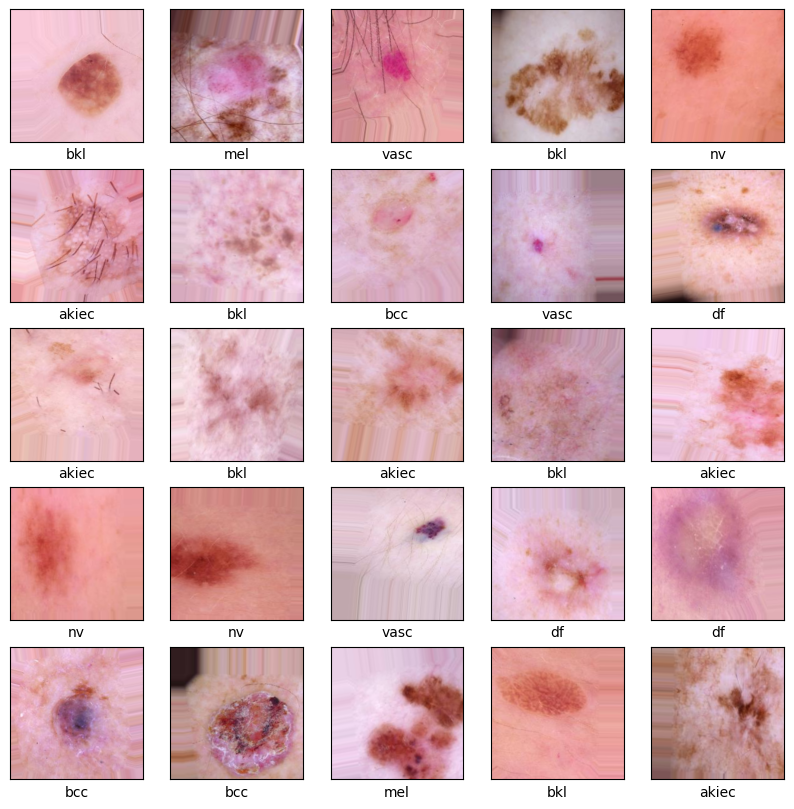

In [ ]:
# @title <p> Get a batch of images and their corresponding labels from the train_generator
images, labels = next(train_generator)

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    label = class_names[np.argmax(labels[i])]
    plt.xlabel(label)
plt.show()


## Modelling

### Model Building

In [ ]:
# @title <p> Build the Model with DenseNet121 Model Function

def densenet_model(IMG_SHAPE):
  pre_trained_model = DenseNet121(include_top=False,
                                  input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
                                  weights='imagenet')

  freeze_index = None
  for i,layer in enumerate(pre_trained_model.layers):
      if 'conv4' in layer._name:
          freeze_index = i
          break

  for layer in pre_trained_model.layers[:freeze_index]:
      layer.trainable = False

  x = pre_trained_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

  callback = myCallback()

  model = tf.keras.models.Model(pre_trained_model.input, outputs)
  return model

In [ ]:
# @title <p> Build the Model with MobileNet Model Function
def mobilenet_model(IMG_SHAPE):
    pre_trained_model = MobileNet(include_top=False,
                                  input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
                                  weights='imagenet')

    # Freezing layers up to a certain point
    freeze_index = None
    for i, layer in enumerate(pre_trained_model.layers):
        if 'conv_dw_11' in layer.name:
            freeze_index = i
            break

    for layer in pre_trained_model.layers[:freeze_index]:
        layer.trainable = False

    x = pre_trained_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(7, activation='softmax')(x)

    model = Model(pre_trained_model.input, outputs)
    return model

In [ ]:
# @title <p> Make a Model
densenet = True #@param {type:'boolean'}
mobilenet = False #@param {type:'boolean'}

if mobilenet:
    model = mobilenet_model(IMG_SHAPE)
if densenet:
    model = densenet_model(IMG_SHAPE)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

## Training

In [ ]:
# @title <p> Train Model
EPOCHS = 1  #@param {type:'integer'}

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=val_generator)

466/466 [==============================] - 298s 526ms/step - loss: 0.8569 - accuracy: 0.6877 - val_loss: 0.9276 - val_accuracy: 0.6997


Text(0.5, 1.0, 'Training and validation loss')

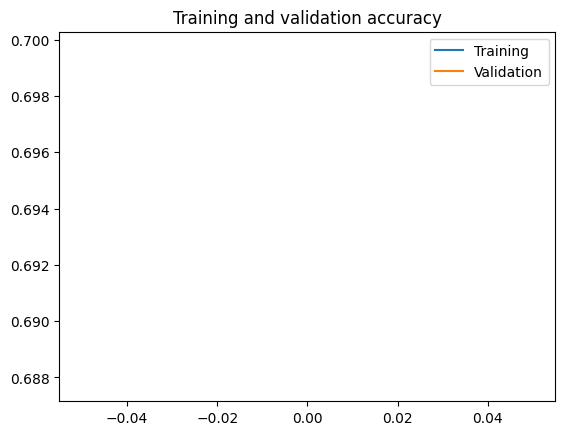

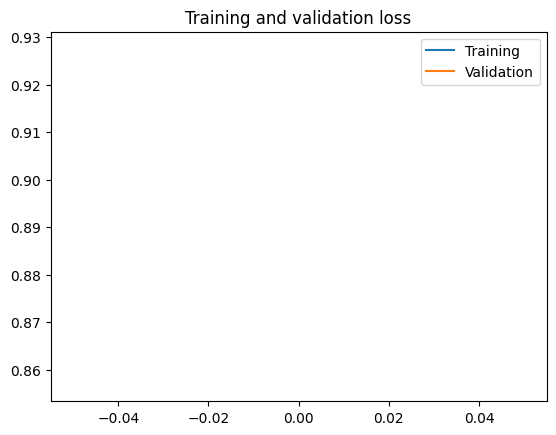

In [ ]:
# @title <p> Training Plot
acc      = history.history.get('accuracy', [])
val_acc  = history.history.get('val_accuracy', [])
loss     = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs, acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot  ( epochs, loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

## Saved Model

In [ ]:
# @title <p> Save the Model
saved_model_path = "./model.h5"
model.save(saved_model_path)

## Export Model

**TFLite**

In [ ]:
# @title <p> Installing tflite-support and downgrade the tensorflow version
!pip install tflite-support &> /dev/null
!pip uninstall tensorflow
!pip install tensorflow=="2.13.0" &> /dev/null

In [ ]:
# @title <p> import dependencies for TFLite
from tflite_support.metadata_writers import writer_utils
from tflite_support.metadata_writers import image_classifier
from tflite_support import metadata

In [ ]:
# @title <p> Restart session to get new model.tflite
TFLITE_MODEL_PATH = 'converted_model.tflite'
MODEL_WITH_METADATA_PATH = 'model_with_metadata.tflite'

# Ingat untuk selalu diganti sama label penyakit yang ditrain!
labels = ["akiec", "bcc", "bkl", "df", "mel", 'nv', 'vasc']

LABEL_FILE = 'labels.txt'
with open(LABEL_FILE, 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

writer = image_classifier.MetadataWriter.create_for_inference(
    model_buffer=writer_utils.load_file(TFLITE_MODEL_PATH),
    input_norm_mean=[127.5],  # Normalization mean
    input_norm_std=[127.5],   # Normalization std
    label_file_paths=[LABEL_FILE]
)

model_with_metadata = writer.populate()

writer_utils.save_file(model_with_metadata, MODEL_WITH_METADATA_PATH)

displayer = metadata.MetadataDisplayer.with_model_file(MODEL_WITH_METADATA_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

**FastAPI**

In [ ]:
# @title <p> Model Deployment using FastAPI
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from PIL import Image
import io

app = FastAPI()

model = load_model('./model.h5')

def preprocess_image(image, target_size):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

@app.post("/predict")
async def predict(image: UploadFile = File(...)):
    contents = await image.read()
    image = Image.open(io.BytesIO(contents))
    processed_image = preprocess_image(image, target_size=(224, 224))

    predictions = model.predict(processed_image)
    class_idx = np.argmax(predictions[0])
    print(predictions)
    return JSONResponse(content={"class": int(class_idx)})


if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="localhost", port=8000)

## Testing

In [ ]:
# @title <p> Evaluation with Test Data (Part A)

model = tf.keras.models.load_model('model.h5')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/final/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

predictions = model.predict(test_generator, steps=test_generator.n//test_generator.batch_size)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)

print(f'The accuracy of the model on the test images is {accuracy * 100:.2f}%')

Found 2144 images belonging to 7 classes.
67/67 [==============================] - 8s 88ms/step
The accuracy of the model on the test images is 85.35%


In [ ]:
# @title <p> Evaluation with Test Data (Part B)
test_image_path = '/content/final/test/bcc/ISIC_0024949_jpg.rf.2627adbdd19f839f759c8fcf60212e97.jpg'

img = image.load_img(test_image_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = img_batch / 255.0

prediction = model.predict(img_preprocessed)

predicted_class = np.argmax(prediction)

predicted_class_name = class_names[predicted_class]

print(f"The predicted class is: {predicted_class}, which corresponds to {predicted_class_name}")

1/1 [==============================] - 0s 54ms/step
The predicted class is: 1, which corresponds to bcc
